## Assignment: $k$ Means Clustering
### **Do Q1 and one other question.**

**Q1.** This is a question about clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

In [2]:
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

2. Make scatterplots of the  (𝑋1,𝑋2)  points by group for each of the datasets. As the noise goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?

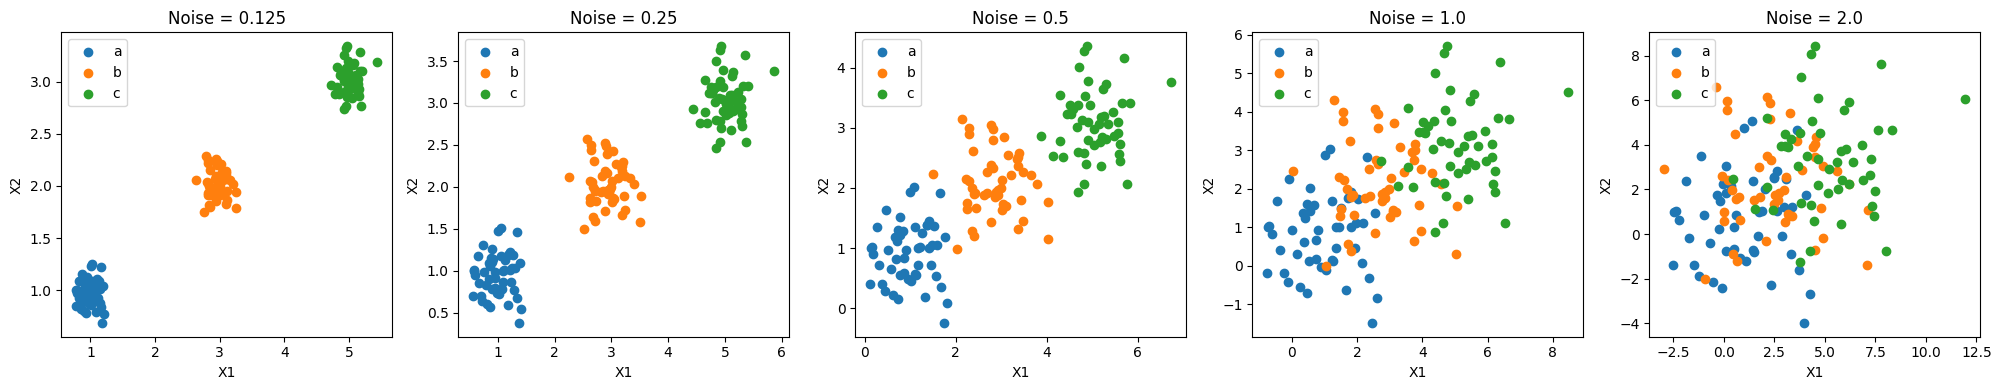

In [3]:
import matplotlib.pyplot as plt

datasets = {
    '0.125': df0_125,
    '0.25': df0_25,
    '0.5': df0_5,
    '1.0': df1_0,
    '2.0': df2_0
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (noise, df) in enumerate(datasets.items()):
    ax = axes[i]
    for group in df['group'].unique():
      subset = df[df['group'] == group]
      ax.scatter(subset['x1'], subset['x2'], label=group)
    ax.set_title(f'Noise = {noise}')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.legend()

plt.tight_layout()
plt.show()


As noise increases, the clusters lose their distinctness, leading to more overlap and making classification harder.

3. Create a scree plot for each of the datasets. Describe how the level of noise affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a  𝑘 . (Pay attention to the vertical axis across plots, or put all the scree curves on a single canvas.)

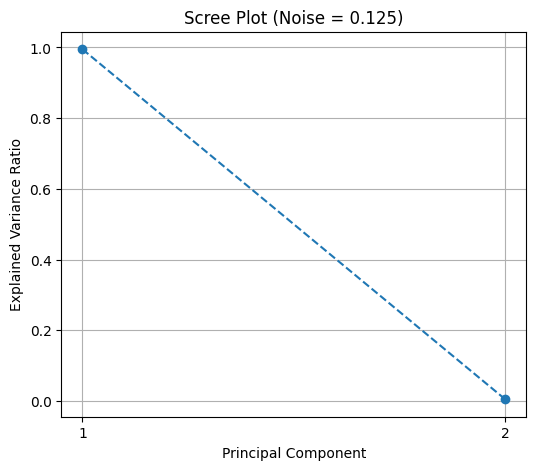

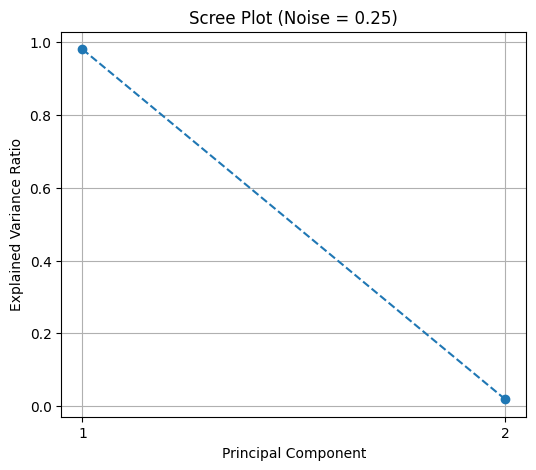

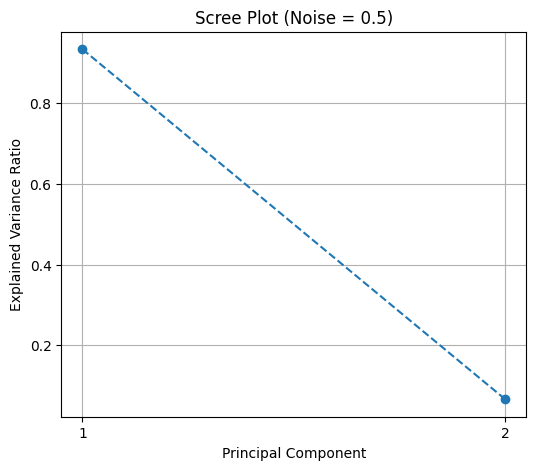

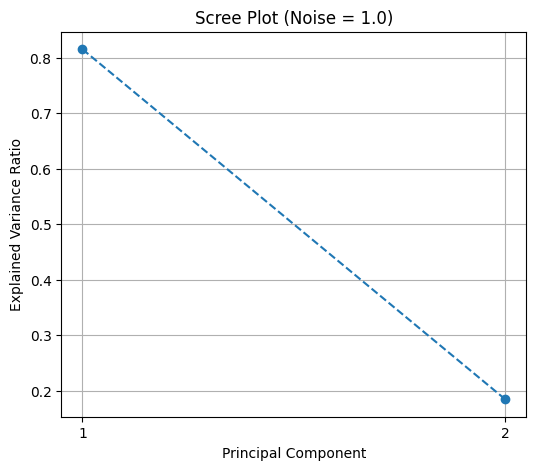

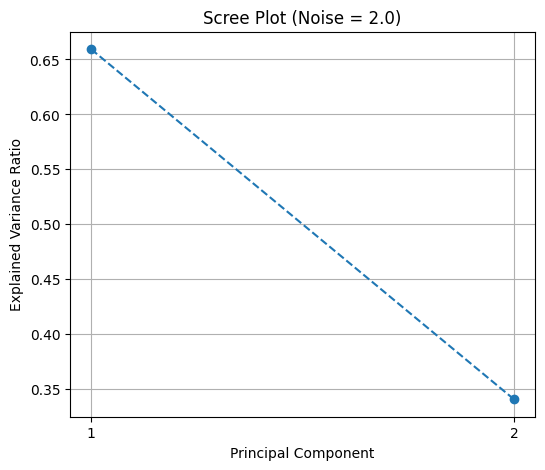

In [6]:
from sklearn.decomposition import PCA

# Function to perform PCA and generate scree plot
def scree_plot(df, noise_level):
    # Extract features (drop the group column)
    X = df.drop(columns=["group"]).values

    # Perform PCA
    pca = PCA()
    pca.fit(X)

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_

    # Create scree plot
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title(f"Scree Plot (Noise = {noise_level})")
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.grid(True)
    plt.show()

# Generate scree plots for each dataset
scree_plot(df0_125, 0.125)
scree_plot(df0_25, 0.25)
scree_plot(df0_5, 0.5)
scree_plot(df1_0, 1.0)
scree_plot(df2_0, 2.0)

Higher noise levels obscure the elbow in the scree plot, making it difficult to determine the optimal number of principal components.

4. Explain the intuition of the elbow, using this numerical simulation as an example.

The elbow point in a scree plot represents the optimal number of principal components (PCs) needed to capture most of the variance in the data. At low noise levels, the elbow is sharp, meaning a few PCs explain most of the variance, making it easy to select k. As noise increases, the variance spreads across more components, the elbow becomes less distinct, and at very high noise levels, there may be no clear elbow, making dimensionality reduction difficult.

**Q4.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.

In [8]:
import pandas as pd

# Load the dataset
file_path = "airbnb_hw.csv"
df = pd.read_csv(file_path)

# Select relevant columns for cleaning
columns_to_clean = ["Price", "Beds", "Number Of Reviews", "Review Scores Rating"]
df_cleaned = df[columns_to_clean].copy()

# Convert Price to numeric (removing any non-numeric characters)
df_cleaned["Price"] = pd.to_numeric(df_cleaned["Price"], errors="coerce")

# Drop rows with missing values in relevant columns
df_cleaned = df_cleaned.dropna()

# Display cleaned dataset
display(df_cleaned.head())

,Price,Beds,Number Of Reviews,Review Scores Rating
4,549.0,3.0,39,96.0
5,149.0,1.0,4,100.0
6,250.0,1.0,9,100.0
7,90.0,1.0,80,94.0
8,270.0,2.0,95,90.0


2. Maxmin normalize the data and remove any nan's (KMeans from sklearn doesn't accept nan input).

In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax normalization to the cleaned data
df_normalized = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Drop any remaining NaN values (if any exist after normalization)
df_normalized = df_normalized.dropna()

# Display normalized dataset
display(df_normalized.head())

,Price,Beds,Number Of Reviews,Review Scores Rating
0,0.544995,0.1875,0.148438,0.950
1,0.140546,0.0625,0.011719,1.000
2,0.242669,0.0625,0.031250,1.000
3,0.080890,0.0625,0.308594,0.925
4,0.262892,0.1250,0.367188,0.875


3. Use sklearn's KMeans module to cluster the data by Beds, Number of Reviews, and Review Scores Rating for k=6.

In [12]:
from sklearn.cluster import KMeans
import pandas as pd

# Select features for clustering
features = ["Beds", "Number Of Reviews", "Review Scores Rating"]
X = df_normalized[features]

# Apply KMeans clustering with k=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(X)

# Display clustered dataset
display(df_normalized.head())

,Price,Beds,Number Of Reviews,Review Scores Rating,Cluster
0,0.544995,0.1875,0.148438,0.950,3
1,0.140546,0.0625,0.011719,1.000,5
2,0.242669,0.0625,0.031250,1.000,5
3,0.080890,0.0625,0.308594,0.925,4
4,0.262892,0.1250,0.367188,0.875,4


4. Use seaborn's .pairplot() to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.

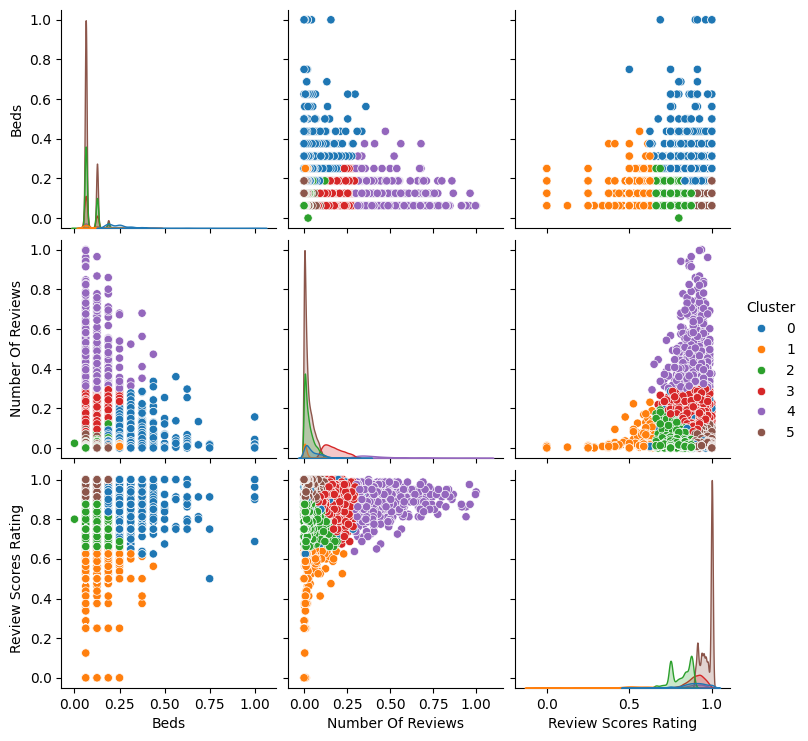

In [14]:
# Re-load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Select features for clustering
features = ["Beds", "Number Of Reviews", "Review Scores Rating"]
X = df_normalized[features]

# Apply KMeans clustering with k=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(X)

# Create a pairplot to visualize clustering in multiple dimensions
sns.pairplot(df_normalized, vars=["Beds", "Number Of Reviews", "Review Scores Rating"], hue="Cluster", palette="tab10")

# Show plot
plt.show()

5. Use .groupby and .describe to compute the average price for each cluster. Which clusters have the highest rental prices?

In [19]:
# Compute the average price for each cluster
cluster_summary = df_normalized.groupby("Cluster")["Price"].describe()

# Display the summary statistics for each cluster
display(cluster_summary)


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1633.0,0.261079,0.169120,0.017189,0.141557,0.217391,0.343782,0.997978
1,630.0,0.117125,0.095279,0.015167,0.055612,0.089990,0.141557,0.797776
2,5524.0,0.121588,0.078353,0.010111,0.065723,0.101112,0.160768,1.000000
3,3005.0,0.132520,0.083434,0.012133,0.077856,0.116279,0.166835,0.894843
4,788.0,0.124638,0.084197,0.017189,0.070779,0.101112,0.160768,0.874621
5,10480.0,0.140560,0.091352,0.000000,0.075834,0.121335,0.182002,0.985844


6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

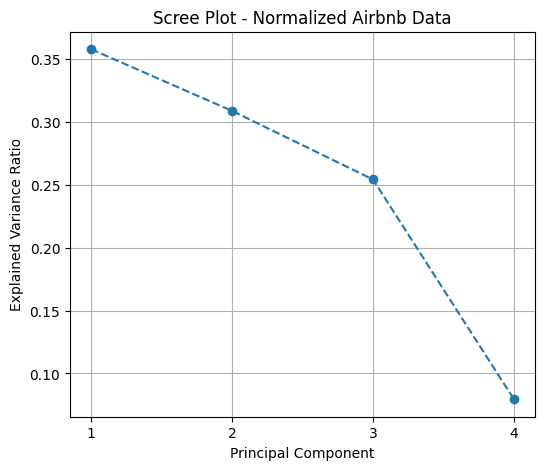

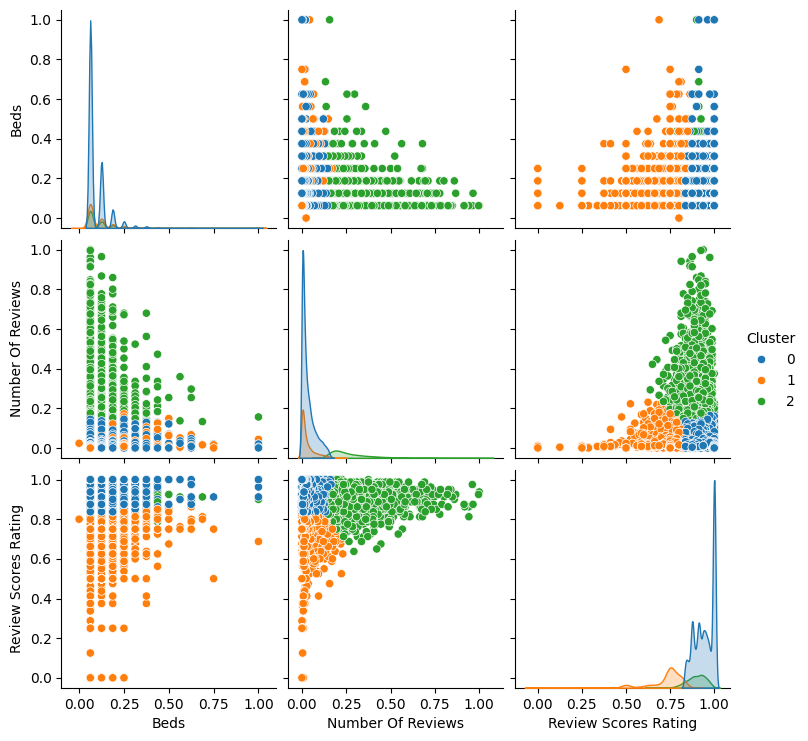

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,15810.0,0.147059,0.103539,0.000000,0.078868,0.121335,0.187058,1.000000
1,3745.0,0.128575,0.097226,0.010111,0.060667,0.101112,0.166835,0.995956
2,2505.0,0.133640,0.090453,0.012133,0.075834,0.111223,0.166835,0.894843


In [21]:
# Function to perform PCA and generate scree plot
def scree_plot(df, title):
    # Extract features (assuming 'Cluster' column exists)
    X = df.drop(columns=["Cluster"]).values

    # Perform PCA
    pca = PCA()
    pca.fit(X)

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_

    # Create scree plot
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title(f"Scree Plot - {title}")
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.grid(True)
    plt.show()

# Generate scree plot for the normalized data
scree_plot(df_normalized, "Normalized Airbnb Data")

# Based on the scree plot, choose the optimal number of clusters (k_new)
k_new = 3 #Example, replace with your observation from the scree plot

# Repeat steps 4 and 5 with the new k value
kmeans_new = KMeans(n_clusters=k_new, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans_new.fit_predict(X)

sns.pairplot(df_normalized, vars=["Beds", "Number Of Reviews", "Review Scores Rating"], hue="Cluster", palette="tab10")
plt.show()

cluster_summary_new = df_normalized.groupby("Cluster")["Price"].describe()
display(cluster_summary_new)